# Data overview

The Cancer Genome Atlas (TCGA) provides genomic and clinical data on over 30 cancer types and around 11,000 samples. These datasets facilitate various analyses, supporting the global cancer research community in discovering novel cancer biomarkers and potential therapeutic targets.

Our combined dataset consists of:
- 10.433 rows (cancer samples)
- 60.660 columns (survival data + gene expression values)

The size of our data file is approximately 3GB.


# Problem overview

We use this data to perform exploratory analysis. Here, for example, we focus on 2 TCGA projects:

- Glioblastoma multiforme (TCGA-GBM) is a highly aggressive type of brain cancer. It is the most common and deadliest form of adult primary brain cancer.
- Lower-grade glioma (TCGA-LGG) are less aggressive types of brain tumors. LGGs grow more slowly and are less malignant than GBM.

Can we use gene expression profiles and survival data to detect differences between those two cancer types? Can we use this kind of workflow for biomarker discovery? For example, studies have shown that mutations in TP53 are associated with various clinical outcomes in LGG patients.


# Analysis overview (Figure below)

1. We perform PCA analysis and observe that expression profiles from LGG and GBM samples are grouped. These similarities could underline common molecular characteristics and pathways, highlighting their origin and progression.

2. We use survival data to generate and plot survival curves for GBM and LGG samples. The aggressiveness of GBM compared to LGG is visible from the plotted survival curves.

3. We then separate LGG patients into two groups based on the median expression value of gene TP53. We again compute and plot the survival curves of both groups. The log-rank test hints that there is a significant difference in survival rates between groups.

Findings from the analysis above could be subjected to further interpretation by domain experts. Testing the hypothesis of various potential gene markers is common in the biomarker discovery process. 


# Challenges?
A challenge arises when considering the computational resources required for such investigations. Our methodology employs well-established Python tools like numpy, pandas, sklearn, and lifelines. Conducting this analysis demands roughly 30GB of system memory—a specification that may not be readily available to many researchers.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from lifelines import KaplanMeierFitter, statistics

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


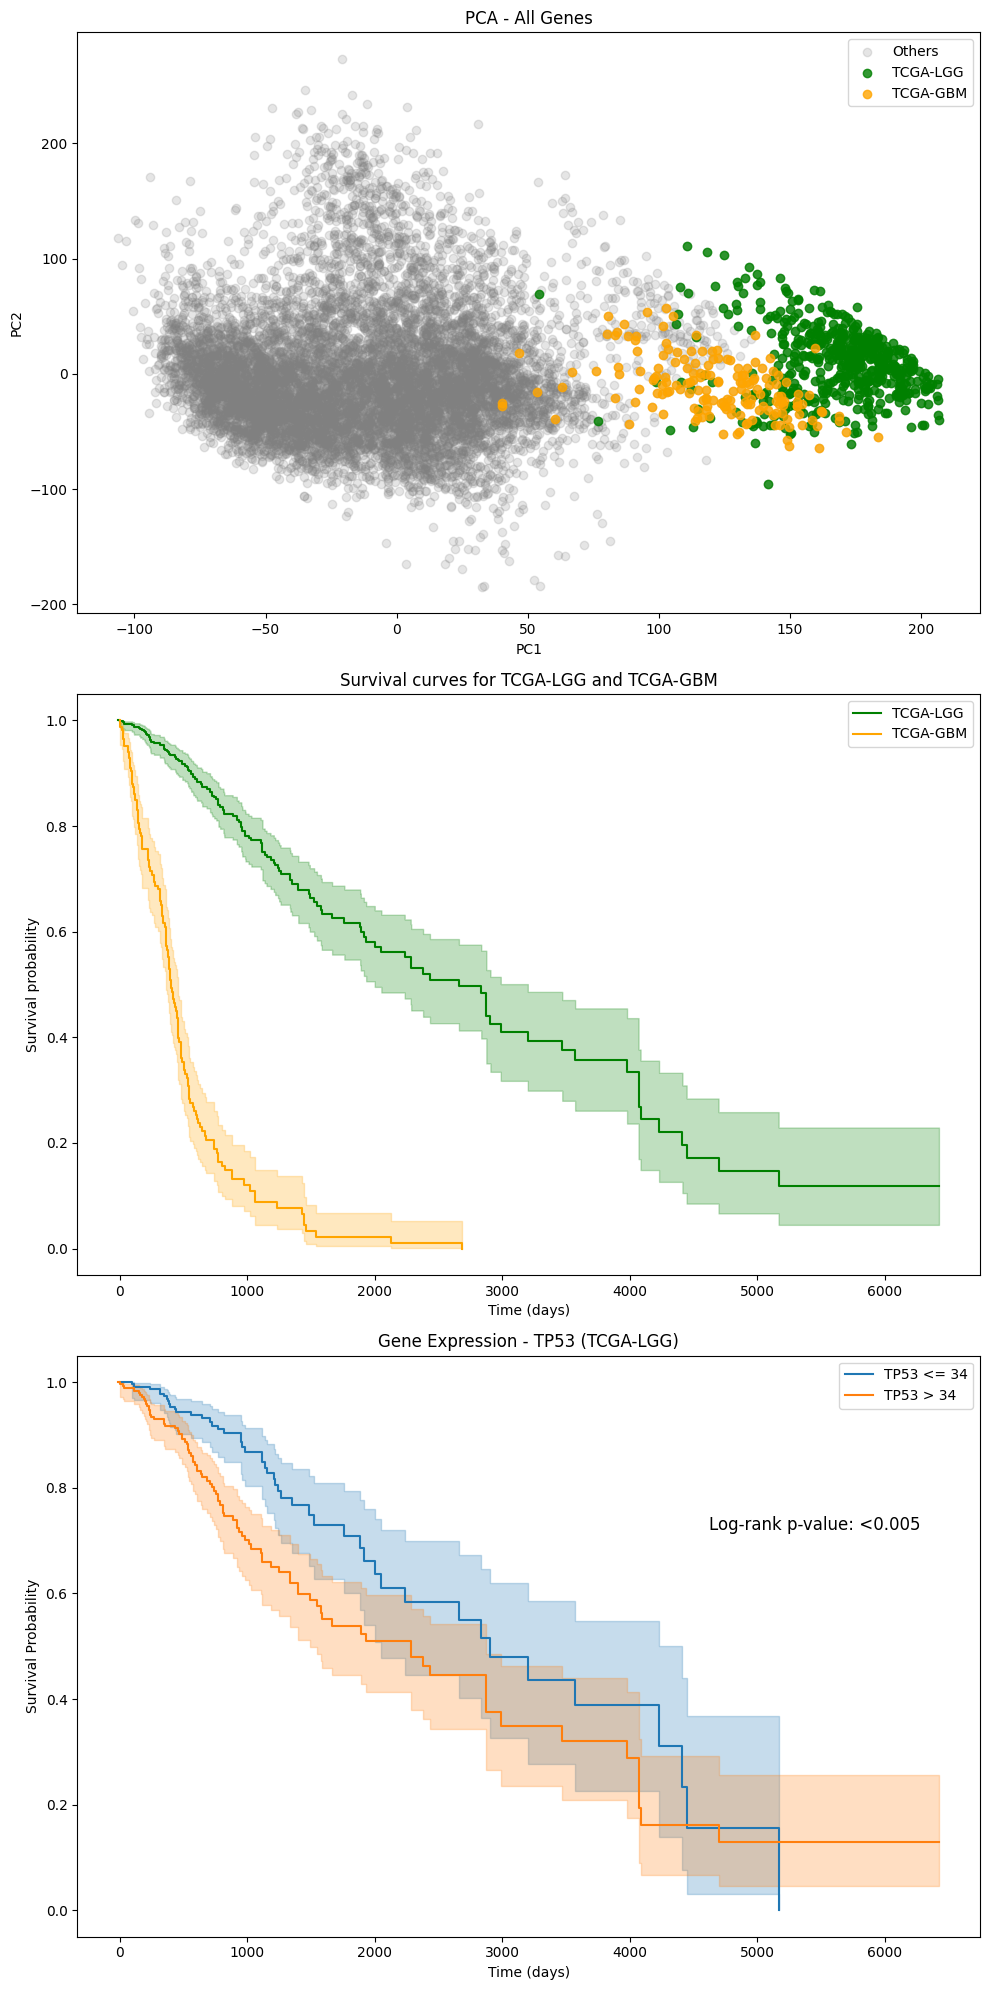

peak memory: 28440.97 MiB, increment: 28244.14 MiB


In [3]:
def plot_pca_results(pca_results, df, ax):
    ax.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.2, color='gray', label='Others')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('PCA - All Genes')

    indexes_lgg = df[df['tcga'] == 'TCGA-LGG'].index.tolist()
    indexes_gbm = df[df['tcga'] == 'TCGA-GBM'].index.tolist()

    ax.scatter(pca_results[indexes_lgg, 0], pca_results[indexes_lgg, 1], alpha=0.8, color='green', label='TCGA-LGG')
    ax.scatter(pca_results[indexes_gbm, 0], pca_results[indexes_gbm, 1], alpha=0.8, color='orange', label='TCGA-GBM')

    ax.legend()
    
def plot_survival_curves(df, label, ax, color=None):
    kmf = KaplanMeierFitter()
    kmf.fit(df['time'], event_observed=df['event'], label=label)
    kmf.plot(ax=ax, ci_show=True, color=color)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Survival probability')
    ax.set_title('Survival curves for TCGA-LGG and TCGA-GBM')

def plot_tp53(df, ax):
    gene_col = [col for col in df.columns if col.startswith('ENSG00000141510')][0]

    filtered_df = df[df['tcga'] == 'TCGA-LGG'][['time','event', gene_col]]
    median = filtered_df[gene_col].median()
    low_group = filtered_df[filtered_df[gene_col] <= median]
    high_group = filtered_df[filtered_df[gene_col] > median]

    kmf = KaplanMeierFitter()
    kmf.fit(durations=low_group['time'], event_observed=low_group['event'], label=f'TP53 <= {round(median)}')
    kmf.plot(ax=ax)
    kmf.fit(durations=high_group['time'], event_observed=high_group['event'], label=f'TP53 > {round(median)}')
    kmf.plot(ax=ax)

    results = statistics.logrank_test(durations_A=low_group['time'], durations_B=high_group['time'],
                                      event_observed_A=low_group['event'], event_observed_B=high_group['event'])
    p_value_str = f"{results.p_value:.4f}" if results.p_value >= 0.005 else "<0.005"

    ax.annotate(f'Log-rank p-value: {p_value_str}', 
                xy=(0.7, 0.7), 
                xycoords='axes fraction', 
                fontsize=12, 
                )

    ax.set_title('Gene Expression - TP53 (TCGA-LGG)')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Survival Probability')


def run_analysis():
    df = pd.read_csv('data/TCGA-combined.csv')
    X = df.iloc[:, 4:]
    X = np.log2(X+1)    
    pca_results =  PCA(n_components=2).fit_transform(X)


    _, axes = plt.subplots(3, 1, figsize=(10, 20))

    plot_pca_results(pca_results, df, axes[0])
    plot_survival_curves(df.loc[df[df['tcga'] == 'TCGA-LGG'].index.tolist()], 'TCGA-LGG', axes[1], color='green')
    plot_survival_curves(df.loc[df[df['tcga'] == 'TCGA-GBM'].index.tolist()], 'TCGA-GBM', axes[1], color='orange')
    plot_tp53(df, axes[2])

    plt.tight_layout()
    plt.show()

%memit run_analysis()
